In [1]:
import pandas as pd
import math
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy.optimize import minimize, least_squares
from gc_aux import r2_score
from sklearn.metrics import mean_absolute_error
from gc_prop_calculation import lhs_cal, y_pred_cal

#### data loading and processing

In [2]:
prop_tag = 'Pc'

In [3]:
#load the data of train set and test set
df1 = pd.read_excel('data/excel_sp/Train_Pc.xlsx')
df2 = pd.read_excel('data/excel_sp/Test_Pc.xlsx')

In [4]:
df_concatenated = pd.concat([df1, df2], ignore_index=True)  

df_concatenated_filtered = df_concatenated.loc[:, (df_concatenated != 0).any(axis=0)]

df1_aft = df_concatenated_filtered.iloc[:len(df1)]  
df2_aft = df_concatenated_filtered.iloc[len(df1):]  

In [5]:
df_grp_cnt = df_concatenated.loc[:,'CH3':]
# extract first order groups and non-zero index
df_fog = df_grp_cnt.iloc[:,:220]
idx_fog = df_fog.sum(axis=0).to_numpy().nonzero()[0]
nr_fog = len(idx_fog)
# extract second order groups and non-zero index
df_sog= df_grp_cnt.iloc[:,220:220+130]
idx_sog = df_sog.sum(axis=0).to_numpy().nonzero()[0]
nr_sog = len(idx_sog)
# extract third order groups and non-zero index
df_tog = df_grp_cnt.iloc[:,220+130:220+130+74]
idx_tog = df_tog.sum(axis=0).to_numpy().nonzero()[0]
nr_tog = len(idx_tog)

In [6]:
df_raw = df1_aft
# extract target values
df_target = df_raw['Const_Value']
# extract all groups
df_grp = df_raw.loc[:,'CH3':]

In [7]:
# extract G
G = df_grp.to_numpy()
G = G[:,:nr_fog+nr_sog+nr_tog].astype('float')
G_fog = G[:,:nr_fog]
G_sog = G[:,nr_fog:nr_fog+nr_sog]
G_tog = G[:,nr_fog+nr_sog:]
# extract y
y = df_target.to_numpy() #*1000

In [ ]:
# for not dividing train and test set

# load the data
df_raw = pd.read_excel('data/new_excels/Pc.xlsx')
# extract target values
df_target = df_raw['Const_Value']
# extract all groups
df_grp = df_raw.loc[:,'CH3':]
# df_grp = df_raw[df_raw.columns[2:]]
# extract first order groups and non-zero index
df_fog = df_grp.iloc[:,:220]
idx_fog = df_fog.sum(axis=0).to_numpy().nonzero()[0]
nr_fog = len(idx_fog)
# extract second order groups and non-zero index
df_sog= df_grp.iloc[:,220:220+130]
idx_sog = df_sog.sum(axis=0).to_numpy().nonzero()[0]
nr_sog = len(idx_sog)
# extract third order groups and non-zero index
df_tog = df_grp.iloc[:,220+130:220+130+74]
idx_tog = df_tog.sum(axis=0).to_numpy().nonzero()[0]
nr_tog = len(idx_tog)

#### Initialization

In [8]:
# define universal constant and calculate lhs
uni_const, lhs = lhs_cal(prop_tag, y)
# initialization of theta
theta_ini = theta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(G),G)),np.transpose(G)),lhs)

mae of fog:2.678890318810842
mae of sog:2.066514384901274
mae of tog:1.5806762193350496
r2 of fog:0.7568654377288809
r2 of sog:0.899249016296829
r2 of tog:0.9339388490039366
are of tog:4.468064219841209
mre of tog:3.1555257435915403


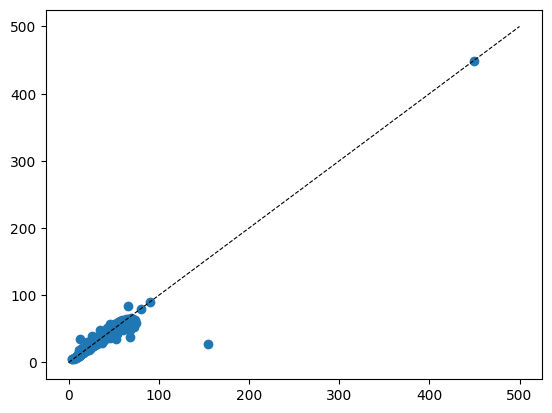

In [19]:
# prediction on each level
y0_fog = y_pred_cal(G_fog, uni_const, theta_ini[:nr_fog], 0, 0, prop_tag)
y0_sog = y_pred_cal(G_sog, uni_const, theta_ini[nr_fog:nr_fog+nr_sog], np.matmul(G_fog, theta_ini[:nr_fog]), 0, prop_tag)
y0_tog = y_pred_cal(G, uni_const, theta_ini, 0, 0, prop_tag)

# calculate mae and r2 for each level
fog_0_r2 = r2_score(y, y0_fog)
fog_0_mae = mean_absolute_error(y,y0_fog)
sog_0_r2 = r2_score(y,y0_sog)
sog_0_mae = mean_absolute_error(y,y0_sog)
tog_0_r2 = r2_score(y,y0_tog)
tog_0_mae = mean_absolute_error(y,y0_tog)
tog_0_are = np.average(np.abs((y - y0_tog) / y))*100
tog_0_mre = np.median(np.abs((y - y0_tog) / y))*100
# printing
print('mae of fog:' + str(fog_0_mae))
print('mae of sog:' + str(sog_0_mae))
print('mae of tog:' + str(tog_0_mae))

print('r2 of fog:' + str(fog_0_r2))
print('r2 of sog:' + str(sog_0_r2))
print('r2 of tog:' + str(tog_0_r2))

print('are of tog:' + str(tog_0_are))
print('mre of tog:' + str(tog_0_mre))

# plot
plt.scatter(y,y0_tog)
plt.plot([0,500],[0,500], color='black', linestyle='--',linewidth=0.8)
# plt.savefig('Parity Plot of y0_tog and y_true for '+prop_tag+'.pdf')
plt.show()

#### Simplex method

In [11]:
# define objective function
def fog_sse_lfvl(fog_params, G, y):
    """
    Funtion to calculate the sum of squared errors of the gc model using first order groups
    :param fog_params: group contributions 
    :param G: group occurrence
    :param y: target values
    :return: 
    """
    y_pred = y_pred_cal(G, fog_params[0], fog_params[1:], 0, 0, prop_tag)    
#     y_pred = y_pred_cal(G, [fog_params[0], fog_params[1], fog_params[2]], fog_params[3:], 0, 0, prop_tag)  #for omega

    errors = y-y_pred
    sse = np.sum(errors ** 2)
    return sse
# define initial params
fog_ini = np.append(uni_const,theta_ini[:nr_fog])
# perform optimization Nelder Mead then L-BFGS-B
result = minimize(fog_sse_lfvl, fog_ini, args=(G_fog, y), jac=None, method='Nelder-Mead',
                  options={'fatol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfev': 300000})
# perform optimization
result = minimize(fog_sse_lfvl, result.x, args=(G_fog, y), jac=None, method='L-BFGS-B',
                  options={'ftol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfun': 300000})
result
fog_simp = result.x

C:\Users\49332\AppData\Local\Temp\ipykernel_16252\1163912891.py:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fog_sse_lfvl, fog_ini, args=(G_fog, y), jac=None, method='Nelder-Mead',


In [13]:
# define objective function for the use of second order groups
def sog_sse_lfvl(sog_params, G2, fog_params, G1, y):
    """
    Funtion to calculate the sum of squared errors of the gc model using second order groups
    :param sogparams: group contributions 
    :param G: group occurrence
    :param y: target values
    :return: 
    """
    fog_contrib = np.matmul(G1, fog_params[1:]) 

    y_pred = y_pred_cal(G2, fog_params[0], sog_params, fog_contrib, 0, prop_tag)
#     y_pred = y_pred_cal(G2, [fog_params[0], fog_params[1], fog_params[2]], sog_params, fog_contrib, 0, prop_tag) #for omega
    
    errors = y-y_pred
    sse = np.sum(errors ** 2)
    return sse
# define initial params
sog_ini = theta_ini[nr_fog:nr_fog+nr_sog]
# perform optimization Nelder Mead then L-BFGS-B
result = minimize(sog_sse_lfvl, sog_ini, args=(G_sog,fog_simp,G_fog, y), jac=None, method='Nelder-Mead',
                  options={'fatol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfev': 300000})
# perform optimization
result = minimize(sog_sse_lfvl, result.x, args=(G_sog,fog_simp,G_fog, y), jac=None, method='L-BFGS-B',
                  options={'ftol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfun': 300000})
result
sog_simp = result.x

C:\Users\49332\AppData\Local\Temp\ipykernel_16252\261937795.py:21: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(sog_sse_lfvl, sog_ini, args=(G_sog,fog_simp,G_fog, y), jac=None, method='Nelder-Mead',


In [14]:
# define objective function for the use of second order groups
def tog_sse_lfvl(tog_params, G3, fog_params, G1, sog_params, G2, y):
    """
    Funtion to calculate the sum of squared errors of the lower flammability limit gc model using third order groups
    :param sogparams: group contributions 
    :param G: group occurrence
    :param y: target values
    :return: 
    """
    fog_contrib = np.matmul(G1, fog_params[1:]) 
    sog_contrib = np.matmul(G2, sog_params) 
    y_pred = y_pred_cal(G3, fog_params[0], tog_params, fog_contrib, sog_contrib, prop_tag)
#     y_pred = y_pred_cal(G3, [fog_params[0], fog_params[1], fog_params[2]], tog_params, fog_contrib, sog_contrib, prop_tag) #for omega
    
    errors = y-y_pred
    sse = np.sum(errors ** 2)
    return sse
# define initial params
tog_ini = theta_ini[nr_fog+nr_sog:]
# perform optimization Nelder Mead then L-BFGS-B
result = minimize(tog_sse_lfvl, tog_ini, args=(G_tog,fog_simp,G_fog, sog_simp, G_sog,y), jac=None, method='Nelder-Mead',
                  options={'fatol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfev': 300000})
# perform optimization
result = minimize(tog_sse_lfvl, result.x, args=(G_tog,fog_simp,G_fog, sog_simp, G_sog,y), jac=None, method='L-BFGS-B',
                  options={'ftol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfun': 300000})
result
tog_simp = result.x

Optimization terminated successfully.
         Current function value: 22899.476135
         Iterations: 31405
         Function evaluations: 37309


mae of fog:1.7007548831654773
mae of sog:1.6573096001704721
mae of tog:1.6250190804313722
r2 of fog:0.9315996893467942
r2 of sog:0.9407619304916289
r2 of tog:0.9433826550940296
are of tog:5.3578190869723565


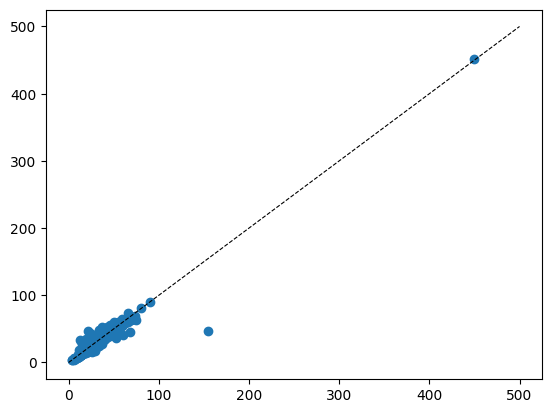

In [18]:
# # prediction on each level
y_simp_fog = y_pred_cal(G_fog, fog_simp[0], fog_simp[1:], 0, 0, prop_tag)
y_simp_sog = y_pred_cal(G_sog, fog_simp[0], sog_simp, np.matmul(G_fog, fog_simp[1:]), 0, prop_tag)
y_simp_tog = y_pred_cal(G_tog, fog_simp[0], tog_simp, np.matmul(G_fog, fog_simp[1:]), np.matmul(G_sog, sog_simp), prop_tag)

# for omega
# y_simp_fog = y_pred_cal(G_fog, [fog_simp[0], fog_simp[1], fog_simp[2]], fog_simp[3:], 0, 0, prop_tag)
# y_simp_sog = y_pred_cal(G_sog, [fog_simp[0], fog_simp[1], fog_simp[2]], sog_simp, np.matmul(G_fog, fog_simp[3:]), 0, prop_tag)
# y_simp_tog = y_pred_cal(G_tog, [fog_simp[0], fog_simp[1], fog_simp[2]], tog_simp, np.matmul(G_fog, fog_simp[3:]), np.matmul(G_sog, sog_simp), prop_tag)

# calculate mae and r2 for each level
fog_simp_r2 = r2_score(y,y_simp_fog)
fog_simp_mae = mean_absolute_error(y,y_simp_fog)
sog_simp_r2 = r2_score(y,y_simp_sog)
sog_simp_mae = mean_absolute_error(y,y_simp_sog)
tog_simp_r2 = r2_score(y,y_simp_tog)
tog_simp_mae = mean_absolute_error(y,y_simp_tog)
tog_simp_are = np.average(np.abs((y - y_simp_tog) / y))*100
tog_simp_mre = np.median(np.abs((y - y_simp_tog) / y))*100
# printing
print('mae of fog:' + str(fog_simp_mae))
print('mae of sog:' + str(sog_simp_mae))
print('mae of tog:' + str(tog_simp_mae))

print('r2 of fog:' + str(fog_simp_r2))
print('r2 of sog:' + str(sog_simp_r2))
print('r2 of tog:' + str(tog_simp_r2))

print('are of tog:' + str(tog_simp_are))

# plot
plt.scatter(y,y_simp_tog)
plt.plot([0,500],[0,500], color='black', linestyle='--',linewidth=0.8)
# plt.savefig('Parity Plot of y_simp_tog and y_true for '+prop_tag+'.pdf')
plt.show()

#### LM method

In [16]:
# define the functions
def fog_residuals(fog_params, G, y):
    """
    
    :param y_exp: 
    :param y_pred: 
    :return: 
    """
    y_pred = y_pred_cal(G, fog_params[0], fog_params[1:], 0, 0, prop_tag)
#     y_pred = y_pred_cal(G, [fog_params[0], fog_params[1], fog_params[2]], fog_params[3:], 0, 0, prop_tag)
    
    errors = y-y_pred
    return errors

def sog_residuals(sog_params, G2, fog_params, G1, y):
    """
    
    :param y_exp: 
    :param y_pred: 
    :return: 
    """
    fog_contrib = np.matmul(G1, fog_params[1:]) 
    y_pred = y_pred_cal(G2, fog_params[0], sog_params, fog_contrib, 0, prop_tag)
#     y_pred = y_pred_cal(G2, [fog_params[0], fog_params[1], fog_params[2]], sog_params, fog_contrib, 0, prop_tag)

    errors = y-y_pred
    return errors
    
def tog_residuals(tog_params, G3, fog_params, G1, sog_params, G2, y):
    """
    
    :param y_exp: 
    :param y_pred: 
    :return: 
    """
    fog_contrib = np.matmul(G1, fog_params[1:]) 
    sog_contrib = np.matmul(G2, sog_params) 
    y_pred = y_pred_cal(G3, fog_params[0], tog_params, fog_contrib, sog_contrib, prop_tag)
#     y_pred = y_pred_cal(G3, [fog_params[0], fog_params[1], fog_params[2]], tog_params, fog_contrib, sog_contrib, prop_tag)    

    errors = y-y_pred
    return errors


result_lm_fog = least_squares(fog_residuals, fog_simp, args=(G_fog, y), method='lm', verbose=2)
fog_lm = result_lm_fog.x

result_lm_sog = least_squares(sog_residuals, sog_simp, args=(G_sog,fog_simp,G_fog, y), method='lm', verbose=2)
sog_lm = result_lm_sog.x

result_lm_tog = least_squares(tog_residuals, tog_simp, args=(G_tog,fog_simp,G_fog, sog_simp, G_sog,y), method='lm', verbose=2)
tog_lm = result_lm_tog.x


`ftol` termination condition is satisfied.
Function evaluations 791, initial cost 1.3661e+04, final cost 1.3647e+04, first-order optimality 2.01e+01.
`ftol` termination condition is satisfied.
Function evaluations 1091, initial cost 1.1869e+04, final cost 1.1868e+04, first-order optimality 1.46e+01.
`ftol` termination condition is satisfied.
Function evaluations 100, initial cost 1.1334e+04, final cost 1.1334e+04, first-order optimality 1.00e+00.


mae of fog:1.6908132116230616
mae of sog:1.6551384201857244
mae of tog:1.6232199271476473
r2 of fog:0.9316694779256935
r2 of sog:0.9408078216467923
r2 of tog:0.9434779806450455
are of tog:5.352847120714645


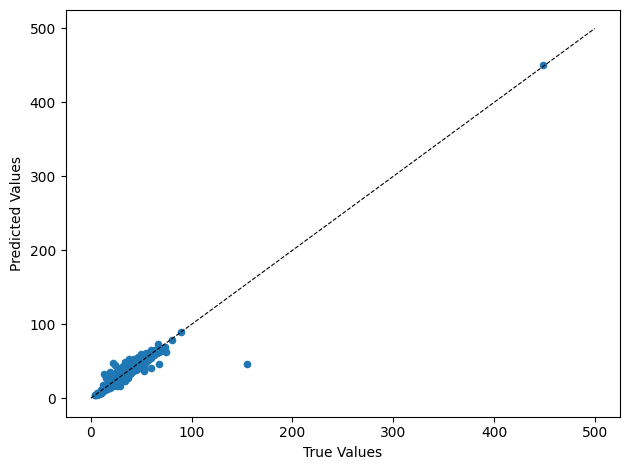

In [17]:
# prediction on each level
y_lm_fog = y_pred_cal(G_fog, fog_lm[0], fog_lm[1:], 0, 0, prop_tag)
y_lm_sog = y_pred_cal(G_sog, fog_lm[0], sog_lm, np.matmul(G_fog, fog_lm[1:]), 0, prop_tag)
y_lm_tog = y_pred_cal(G_tog, fog_lm[0], tog_lm, np.matmul(G_fog, fog_lm[1:]), np.matmul(G_sog, sog_lm), prop_tag)

# for omega
# y_lm_fog = y_pred_cal(G_fog, [fog_lm[0],fog_lm[1],fog_lm[2]], fog_lm[3:], 0, 0, prop_tag)
# y_lm_sog = y_pred_cal(G_sog, [fog_lm[0],fog_lm[1],fog_lm[2]], sog_lm, np.matmul(G_fog, fog_lm[3:]), 0, prop_tag)
# y_lm_tog = y_pred_cal(G_tog, [fog_lm[0],fog_lm[1],fog_lm[2]], tog_lm, np.matmul(G_fog, fog_lm[3:]), np.matmul(G_sog, sog_lm), prop_tag)

# calculate mae and r2 for each level
fog_lm_r2 = r2_score(y,y_lm_fog)
fog_lm_mae = mean_absolute_error(y,y_lm_fog)
sog_lm_r2 = r2_score(y,y_lm_sog)
sog_lm_mae = mean_absolute_error(y,y_lm_sog)
tog_lm_r2 = r2_score(y,y_lm_tog)
tog_lm_mae = mean_absolute_error(y,y_lm_tog)
tog_lm_are = np.average(np.abs((y - y_lm_tog) / y))*100
# printing
print('mae of fog:' + str(fog_lm_mae))
print('mae of sog:' + str(sog_lm_mae))
print('mae of tog:' + str(tog_lm_mae))

print('r2 of fog:' + str(fog_lm_r2))
print('r2 of sog:' + str(sog_lm_r2))
print('r2 of tog:' + str(tog_lm_r2))

print('are of tog:' + str(tog_lm_are))

# plot
plt.scatter(y,y_lm_tog,s=20)
plt.plot([0, 500], [0, 500], color='black', linestyle='--',linewidth=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

# plt.savefig('Parity Plot of y_lm_tog and y_true for '+prop_tag+'.pdf')
plt.show()